In [2]:
import sys, os
import json, time
import requests
# from botocore.vendored import requests
import pandas as pd
from datetime import datetime
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource
# from bokeh.layouts import column
# from bokeh.embed import components
# from bokeh.io import output_file

import boto3
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError



def get_ssm_parameter(parameter_name):
    ssm_client = boto3.client('ssm')
    response = ssm_client.get_parameter(Name=parameter_name, WithDecryption=True)
    return response['Parameter']['Value']
config = json.loads(get_ssm_parameter('/openweather/config'))



bucket_name = config['bucket_name']
key = config['key']
AWS_REGION = config['AWS_REGION']
SENDER = config['SENDER']
RECIPIENT = config['RECIPIENT']
SUBJECT = config['SUBJECT']
BODY_TEXT = config['BODY_TEXT']
CHARSET = config['CHARSET']
api_key = config['api_key']
base_url = config['base_url']
s3_url = config['s3_url']

latitude = 45.4141
longtitude = -122.7957

current_time_key = str(int(time.time()))
current_time = datetime.fromtimestamp(int(current_time_key)).strftime("%Y-%m-%d %H:%M:%S")

ses_client = boto3.client("ses", region_name=AWS_REGION)
s3 = boto3.client('s3')
    

def send_email(BODY_HTML):
    try:
        response = ses_client.send_email(
            Source=SENDER,
            Destination={
                "ToAddresses": [RECIPIENT],
            },
            Message={
                "Subject": {
                    "Data": SUBJECT,
                    "Charset": CHARSET,
                },
                "Body": {
                    "Text": {
                        "Data": BODY_TEXT,
                        "Charset": CHARSET,
                    },
                    "Html": {
                        "Data": BODY_HTML,
                        "Charset": CHARSET,
                    },
                },
            },
        )
        print("Email sent! Message ID:"),
        print(response["MessageId"])
    except ClientError as e:
        print(f"Error sending email: {e.response['Error']['Message']}")
def get_weather_data(lat,lon):
    complete_url = base_url + "appid=" + api_key + "&lat="+ str(lat) + "&lon=" + str(lon)
    response = requests.get(complete_url)

    data = response.json()
    ## denormalize the json data
    df = pd.json_normalize(data)

    list_expanded = pd.json_normalize(df['list'].explode().dropna())
    list_expanded['weather'] = list_expanded['weather'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

    weather_expanded = pd.json_normalize(list_expanded['weather'])
    list_expanded = pd.concat([list_expanded.drop(columns=['weather']).reset_index(drop=True), 
                            weather_expanded.reset_index(drop=True)], axis=1)
    city_data = df.drop(columns=['list']).iloc[0]  
    city_repeated = pd.DataFrame([city_data] * len(list_expanded)).reset_index(drop=True)
    denormalized_df = pd.concat([city_repeated, list_expanded.reset_index(drop=True)], axis=1)
    # denormalized_df['dt_txt']
    # from datetime import  datetime
    # time_str= "2024-11-10 00:00:00"
    # datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    denormalized_df['dt_txt'] = pd.to_datetime(denormalized_df['dt_txt'], format='%Y-%m-%d %H:%M:%S')
    obj = 'denormalized_weather_output.csv'
    denormalized_df.to_csv(obj, index=False)
    s3.upload_file(obj, bucket_name, key+current_time_key+'/'+obj)
    return denormalized_df
def plot_weather_data_bokeh(df):
    # Plotting the data
    # source = ColumnDataSource(denormalized_df)
    # p = figure(title="Temperature vs Time", x_axis_label='Date', y_axis_label='Temperature (K)', x_axis_type='datetime')
    # p.line('dt_txt', 'main.temp', source=source, legend_label="Temperature", line_width=2, color="blue")
    # p.line('dt_txt', 'main.feels_like', source=source, legend_label="Feels Like", line_width=2, color="red")
    # p.legend.location = "top_left"
    # p.legend.title = 'Weather Parameters'
    # p.xaxis.major_label_orientation = 1.2
    # p.grid.grid_line_alpha = 0.3
    # from bokeh.io import output_file
    # show(p)
    # output_file("temperature_plot.html")
    pass
def plot_weather_data_matplotlib(df):
    img = []
    plt.figure(figsize=(10, 5))
    plt.plot(df['dt_txt'], df['main.temp'], label='Temperature (K)', color='tab:red')
    plt.xlabel('Time')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature vs. Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('temperature_vs_time.png')
    img.append('temperature_vs_time.png')
    # plt.show()

    # Humidity vs. Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['dt_txt'], df['main.humidity'], label='Humidity (%)', color='tab:blue')
    plt.xlabel('Time')
    plt.ylabel('Humidity (%)')
    plt.title('Humidity vs. Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('humidity_vs_time.png')
    img.append('humidity_vs_time.png')
    # plt.show()

    # Wind Speed vs. Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['dt_txt'], df['wind.speed'], label='Wind Speed (m/s)', color='tab:green')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed (m/s)')
    plt.title('Wind Speed vs. Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('wind_speed_vs_time.png')
    img.append('wind_speed_vs_time.png')
    # plt.show()

    # Rain vs. Time
    plt.figure(figsize=(10, 5))
    plt.plot(df['dt_txt'], df['rain.3h'], label='Rain (mm)', color='tab:purple')
    plt.xlabel('Time')
    plt.ylabel('Rain (mm)')
    plt.title('Rain vs. Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('rain_vs_time.png')
    img.append('rain_vs_time.png')
    # plt.show()
    
    return img
    

def handler(event={}, context={}):
    print("Received event: " + json.dumps(event, indent=2))
    df = get_weather_data(latitude,longtitude)
    # plot_weather_data_bokeh(df)
    images = plot_weather_data_matplotlib(df)
    # images =[ 'temperature_vs_time.png','humidity_vs_time.png','wind_speed_vs_time.png','rain_vs_time.png']
    # current_time_key = str(int(time.time()))
    # current_time = datetime.fromtimestamp(int(time_fl)).strftime("%Y-%m-%d %H:%M:%S")
    for obj in images:
        s3.upload_file(obj, bucket_name, key+current_time_key+'/'+obj)
        print(f"File {obj} uploaded successfully to {bucket_name}/{obj}")

    BODY_HTML="""
    <h1>Report Generated at : {4}</h1>
    <h2>Temperature Over Time</h2><img src="{6}/{5}/{0}" alt="{0}" width="500"><br>
    <h2>Humidity Over Time</h2><img src="{6}/{5}/{1}" alt="{1}" width="500"><br>
    <h2>Wind_speed Over Time</h2><img src="{6}/{5}/{2}" alt="{2}" width="500"><br>
    <h2>Rain Over Time</h2><img src="{6}/{5}/{3}" alt="{3}" width="500"><br>
    """.format(images[0],images[1],images[2],images[3],current_time,current_time_key,s3_url)
    
    send_email(BODY_HTML)
    

Received event: {}
File temperature_vs_time.png uploaded successfully to riding-videos-tony/temperature_vs_time.png
File humidity_vs_time.png uploaded successfully to riding-videos-tony/humidity_vs_time.png
File wind_speed_vs_time.png uploaded successfully to riding-videos-tony/wind_speed_vs_time.png
File rain_vs_time.png uploaded successfully to riding-videos-tony/rain_vs_time.png
Email sent! Message ID:
0101019317cdebb8-60034204-4b10-41a6-8a36-50d8a26ea64f-000000


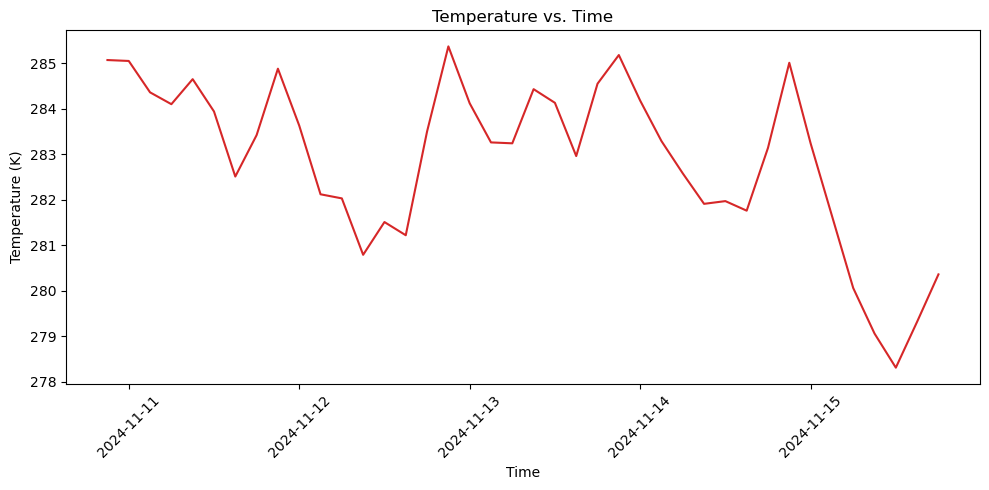

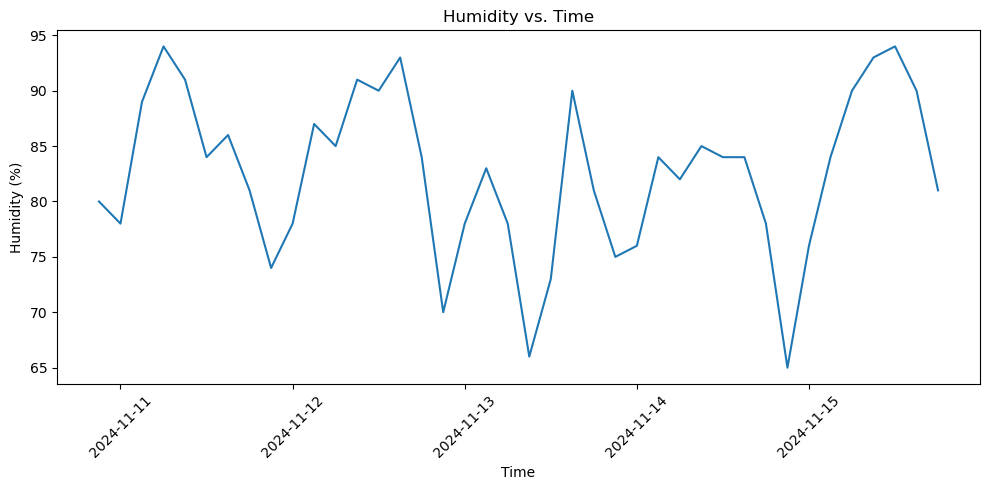

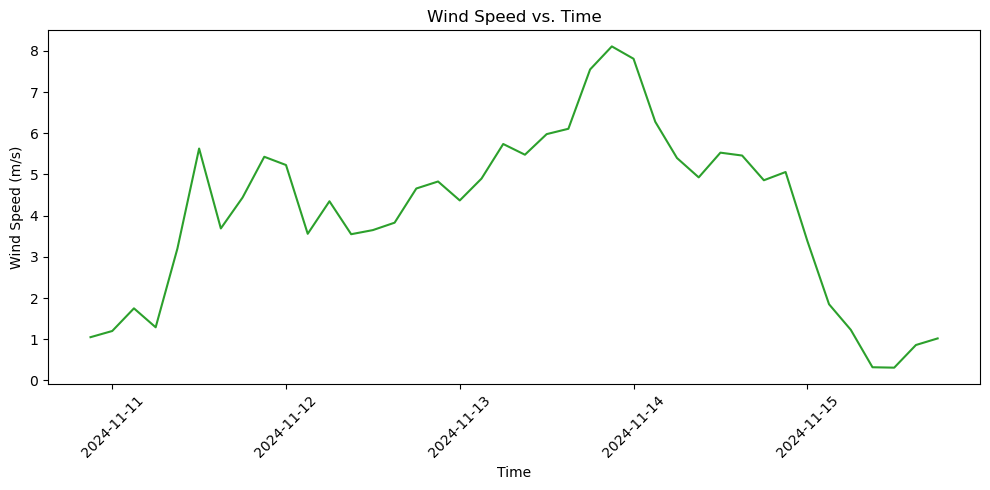

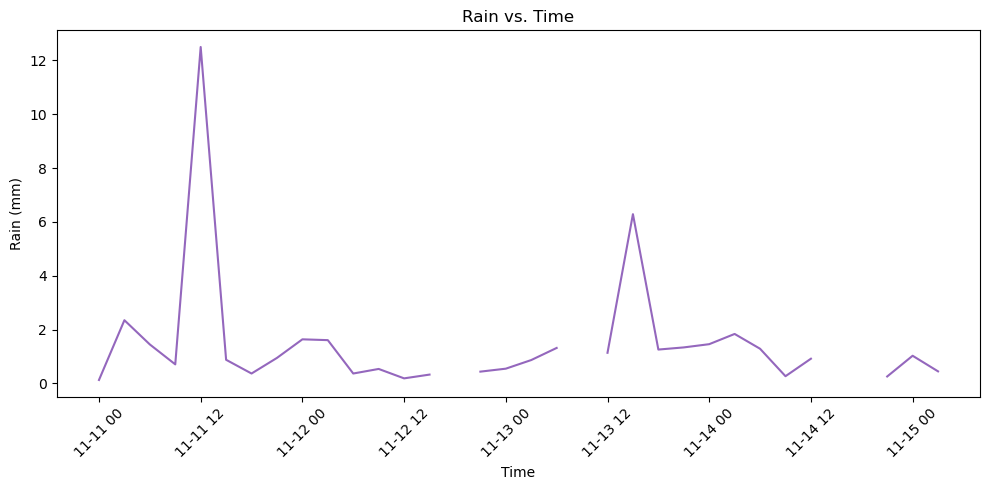

In [3]:

handler()
